In [1]:
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import mpld3
mpld3.enable_notebook()

In this notebook, I will explore the SIR model looking at three regions in germany. After that, I will look at a way to include two dependent regions in one model. I used [this article](https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc) and borrowed a lot of the authors code to get an introduction into SIR models and create this notebook. 

## Define parameters for simulated data for berlin

In [2]:
N1 = 3645000
beta1 = 0.28  # infected person infects 0.28 other person per day
D = 5 # assuming you are infectious for 5 days
gamma = 1.0 / D

I01, R01 = 3069, 186455  # initial conditions as of september 11 2021: 3069 infected, 186455 recovered
S01 = N1 - I01 - R01 # number of susceptible people

### SIR formula 

In [3]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [4]:
t = np.linspace(0, 380, 381) # Grid of time points (in days) (381 days in RKI dataset)
y01 = S01, I01, R01 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret1 = odeint(deriv, y01, t, args=(N1, beta1, gamma))
S1, I1, R1 = ret1.T

### plot

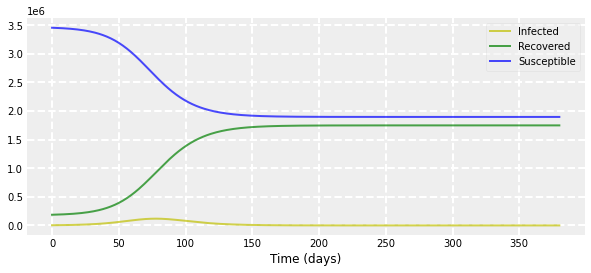

In [18]:
def plotsir(t, S, I, R, full_graph = False):
  f, ax = plt.subplots(1,1,figsize=(10,4))
#  plt.style.use("bmh")
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')  

  if full_graph == True:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='--')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

plotsir(t, S1, I1, R1, full_graph = True)

This model expects a peak around 75 days after the initial state and a steady drop in cases following. Let us look at the actual data from Berlin. I created a csv file from the 2021 data that you can get at the [RKI website](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Kum_Tab.html)

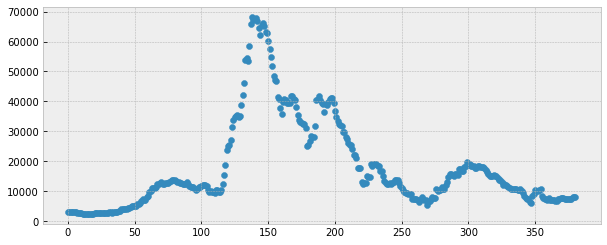

In [17]:
dat = pd.read_csv("fallzahlen.csv", sep = ";")

# restructure dataframe in long format
list_dates = dat.drop(["MeldeLandkreisBundesland"], axis=1).columns
dat_long = pd.melt(dat, id_vars = "MeldeLandkreisBundesland", var_name = "datum", value_vars=list_dates,value_name='fallzahl', ignore_index=False)
dat_long = dat_long.reset_index(drop = True)

# extract berlin data
berlin = dat_long.loc[dat_long["MeldeLandkreisBundesland"] == "Berlin"].reset_index(drop = True)
# plot data for berlin

fig, ax = plt.subplots(figsize=(10, 4))
plt.style.use("bmh")

ax.scatter(x = t, y = berlin["fallzahl"])

#fig.savefig("jahresverlauf.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

In the real data, the peak of cases does seem to be around 80 days with a slow drop following, however there is a sudden increase starting at around 115 days. This is likely due to the omicron variant hitting berlin, which changes the rate at which an infected person infects others (beta) but also increases the chance of reinfection, which a simple SIR model does not account for. To solve the first problem, we could adjust beta such that it changes if t is larger than ~115. For the second problem, we could put recovered people back into the susceptible-compartment with a certain probability, which we derive from empirical data. 

Another problem is that the absolute case numbers are overestimated. To have a more realistic model, we would need to include variables such as vaccinated and boosted (which also changed over time), and vary beta based on the measurements that were in place.

Another observation is that in the real world data, case numbers increase more rapidly at the beginning and slow down. This is probably because peoples behavior changes if cases go up, which has an effect on the reproduction rate. We can account for this and for omicron by making beta time and case-number dependent: 

In [7]:
def beta_t(t, I):
    return 0.65 if (t < 115) & (I < 5000) else 0.3 if (t < 115) & (I > 5000) else 0.8

# explanation: Before omicron, beta is 0.65 but drops to 0.3 once cases reach 5000, after omicron beta is at 0.8



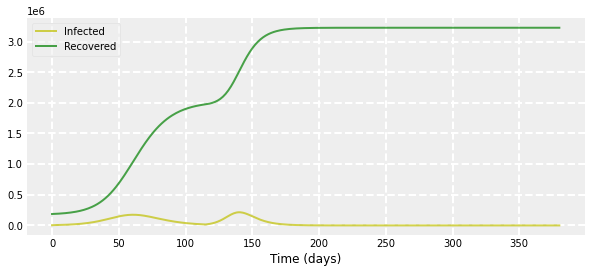

In [8]:
def deriv_t(y, t, N, beta_t, gamma):
    S, I, R = y
    dSdt = -beta_t(t, I) * S * I / N
    dIdt = beta_t(t, I) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Integrate the SIR equations over the time grid, t.
ret12 = odeint(deriv_t, y01, t, args=(N1, beta_t, gamma))
S12, I12, R12 = ret12.T
plotsir(t, S12, I12, R12)

This graph somewhat resembles the first two waves in the timepoint of their peaks, but the absolute numbers are vastly overestimated. 

For the next steps, we will focus on that first delta wave and ignore the following omicron wave.

Now let us look at a region that is less densely populated and does not have a close proximity to a large city. First, we try to model it, expecting a slightly lower reproduction rate due to the lower population density. We will take the case of mecklenburg vorpommern

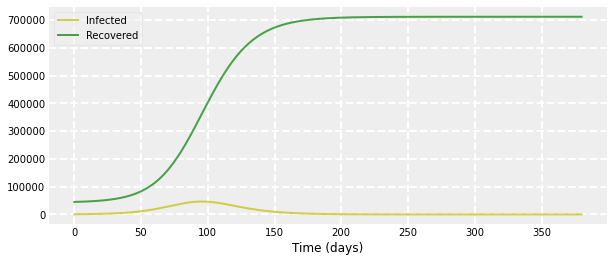

In [9]:
N2 = 1610000 
beta2 = 0.268  # infected person infects 0.24 other person per day
D = 5.0 # infections lasts ten days
gamma = 1.0 / D

I02, R02 = 626, 44982  # initial conditions as of september 11 2021: 626 infected, 44982 recovered (estimated based on coronamap-mv.de)
S02 = N2 - I02 - R02 # number of susceptible people

y02 = S02, I02, R02 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret2 = odeint(deriv, y02, t, args=(N2, beta2, gamma))
S2, I2, R2 = ret2.T

plotsir(t, S2, I2, R2)

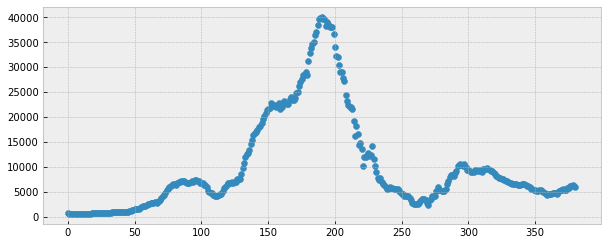

In [10]:
# extract mecklenburg-vorpommern data
mv = dat_long.loc[dat_long["MeldeLandkreisBundesland"] == "Mecklenburg-Vorpommern"].reset_index(drop = True)

# plot data for brandenburg

fig, ax = plt.subplots(figsize=(10, 4))
plt.style.use("bmh")

ax.scatter(x = t, y = mv["fallzahl"])

#fig.savefig("jahresverlauf.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

We were somewhat able to remodel the delta wave by setting a lower reproduction rate (but again, the absolute numbers are still vastly off). Now let us look at Brandenburg, a region that is also sparsly populated, but in close proximity to berlin.  

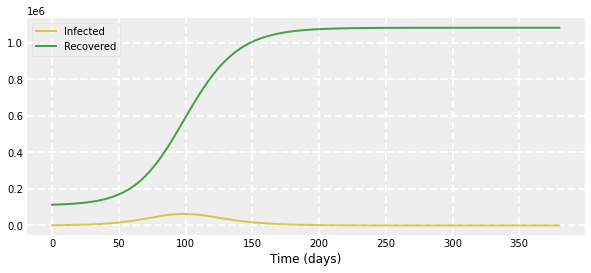

In [11]:
N3 = 2512000 
beta3 = 0.268  # infected person infects 0.185 other person per day
D = 5.0 # infections lasts ten days
gamma = 1.0 / D

I03, R03 = 1082, 113184  # initial conditions as of september 11 2021: 3069 infected, 113184 recovered (estimated based on cumulative cases according to rbb)
S03 = N3 - I03 - R03 # number of susceptible people

y03 = S03, I03, R03 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret3 = odeint(deriv, y03, t, args=(N3, beta3, gamma))
S3, I3, R3 = ret3.T

plotsir(t, S3, I3, R3)

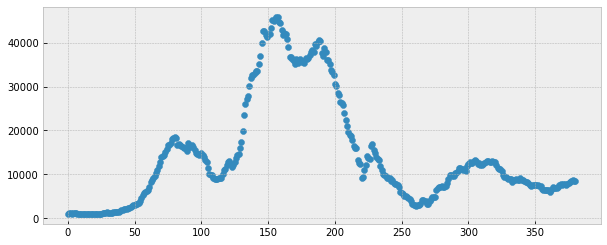

In [12]:
# extract brandenburg data
branne = dat_long.loc[dat_long["MeldeLandkreisBundesland"] == "Brandenburg"].reset_index(drop = True)
branne["genesen"] = 113184 + branne["fallzahl"].shift(10)
branne = branne.fillna(113184) #for the first 10 days of this timeframe we assume that the number of recovered does not change

# plot data for brandenburg

fig, ax = plt.subplots(figsize=(10, 4))
plt.style.use("bmh")

ax.scatter(x = t, y = branne["fallzahl"])

#fig.savefig("jahresverlauf.pdf", bbox_inches = "tight", pad_inches = 0, dpi=10, format = "pdf")
plt.show()

The wave in Brandenburg has its peak closer to the wave in berlin, despite the structural similarity to Mecklenburg-Vorpommern. Curiously, the slope first is more similar to the one in Mecklenburg-Vorpommern, before suddenly increasing even more than in Berlin. One explanation for this is that infections in Brandenburg are not independent of those in Berlin. A share of the people living in one of the regions works in the other, and there are also social ties between those two regions. So the higher the number of infections in one region, the higher the chance of a spillover into the other region.

A second effect might be at play: Because vaccination rates in Brandenburg are low, we would expect a higher reproduction rate than in Berlin. However, people in Berlin "mix" more strongly with the entire population in their everyday live and social networks are more sparse, allowing infections to travel through networks faster. So, one interpretation is as follows: As long as case numbers in Brandenburg are low, the reproduction rate stays low, because people in Brandenburg don't mix with the entire population as much as people in Berlin, and therefore stay isolated within dense social networks. Once cases are spread out accross the Brandenburg network, the reproduction rate also increases.

A way to model this is to make beta3, the reproduction rate in brandenburg, dependent on beta, the reproduction rate in berlin. We do this by including another parameter, alfa, which is a function of beta1.

In [13]:
def deriv_coupled(y, t, N1, N3, beta1, beta3, gamma, log_alfa):
    S1, I1, R1, S3, I3, R3 = y
    
    dSdt1 = -beta1 * S1 * I1 / N1
    dIdt1 = beta1 * S1 * I1 / N1 - gamma * I1
    dRdt1 = gamma * I1

    dSdt2 = -beta3 * alfa(I1) * S3 * I3 / N3
    dIdt2 = beta3 * alfa(I1) * S3 * I3 / N3 - gamma * I3
    dRdt2 = gamma * I3
    
    return dSdt1, dIdt1, dRdt1, dSdt2, dIdt2, dRdt2

In [14]:
# alfa is a function of I1
# In this case it is a very simple function: If the number of cases in I1 (berlin) is larger than 6000, alfa is 1.065
# Since alfa is multiplied with beta2, this changes the reproduction rate beta3 from 0.268 to 0.285
def alfa(I1):
    return 1 if I1 < 6000 else 1.065 

In [15]:
y04 = S01, I01, R01, S03, I03, R03
# Integrate the SIR equations over the time grid, t.
ret4 = odeint(deriv_coupled, y04, t, args=(N1, N3, beta1, beta3, gamma, alfa))
S1, I1, R1, S2, I2, R2 = ret4.T

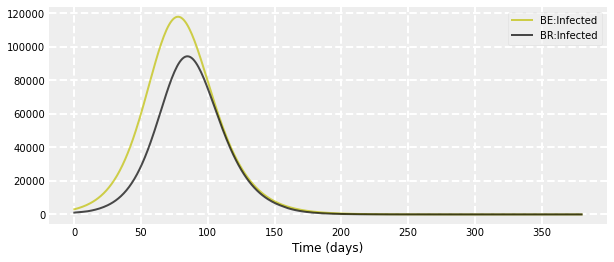

In [16]:
f, ax = plt.subplots(1,1,figsize=(10,4))
#  plt.style.use("bmh")
#ax.plot(t, S1, 'b', alpha=0.7, linewidth=2, label='BE:Susceptible')
ax.plot(t, I1, 'y', alpha=0.7, linewidth=2, label='BE:Infected')
#ax.plot(t, R1, 'g', alpha=0.7, linewidth=2, label='BE:Recovered')

#ax.plot(t, S2, 'r', alpha=0.7, linewidth=2, label='BR:Susceptible')
ax.plot(t, I2, 'k', alpha=0.7, linewidth=2, label='BR:Infected')
#ax.plot(t, R2, 'w', alpha=0.7, linewidth=2, label='BR:Recovered')

ax.set_xlabel('Time (days)')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='--')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
  ax.spines[spine].set_visible(False)
plt.show()



The black line for infections in Brandenburg (BR: Infected) now resembles its real-world counterpart more closely, because the increase becomes steeper once Berlin crosses a threshold, and the peak is closer to the actual peak. 

### Limitations and outlook
With this strategy, we are basically assuming that the reproduction rate in brandenburg increases when the case number in berlin increases. In the real world, this does not perfectly describe the mechanisms at play. A more accurate description is that the risk of getting infected for a random person in brandenburg increases when the risk of getting infected for a ranodm person in berlin increases. However, in practice this strategy can lead to helpful results, because it allows us to look at brandenburg in isolation, while still accounting for the situation in berlin. 

In this example, I used a basic if-else statement to make beta3 dependent on I1. A jump in the reproduction rate like this is unrealistic. A logistic function would be a better representation. I ran into some issues while implementing this and decided to leave it in the if-else version for now. Another option would be to have beta3 be a regression model that can take multiple predictors. We could also train a model that predicts the reproduction rate in the neighboring region based on data from the main region, while controlling for the lagged case numbers in the neighboring region to study the relationship between those two. This might further give clues as to how those two parameters are related. 
    